# Deep Learning HW1
# David Pitts 313371080
# Aner Zakobar 203340302

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse

import numpy as np


Gradient checking


In [2]:
def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm

In [3]:
y_hot=pd.get_dummies(np.arange(10))

def getLoss(w,x,y):
    """
    Forward for a simple softmax regression ,
    :param w:  weights
    :param x:
    :param y:
    :return: the loss and the gradient .
    """
    y_mat=np.array(y_hot[y])
    scores = np.dot(x,w)
    prob = softmax(scores)
    loss = (-1) * np.sum(y_mat.T * np.log(prob))
    grad = -(1) * (x.T@(y_mat.T - prob))
    return loss,grad


In [4]:
def gradient_test_softmax_reg():
    """
    Performs a gradient test for softmax regression ,
    the data and weights are intilized randomly inside the function.
    :return:
    """
    values_linear=[]
    values_quard=[]
    epsilon=2

    w=np.random.random((10,10))
    x=np.random.random((1,10))
    y=np.random.randint(0,10,size=(1))

    f0 = getLoss(w, x, y)[0]
    grad = getLoss(w, x, y)[1]

    b = np.random.random(w.shape)
    b= b/np.linalg.norm(b,ord=2)

    gradient_test_convergence(b, epsilon, f0, grad, values_linear, values_quard, w, x, y)


    values_quard=np.array(values_quard)
    values_linear=np.array(values_linear)
    return values_quard,values_linear


def gradient_test_convergence(b, epsilon, f0, grad, values_linear, values_quard, w, x, y):
    """
    Performs the loop which saves the values of the gradient test for each iteration.
    :param b: random vector of weights
    :param epsilon:
    :param f0: the value of the function with out epsilon
    :param grad:  the gradient of the function without epsilon
    :param values_linear:  list of the linear values
    :param values_quard: list of the quard values
    :param w: wieghts
    :param x:
    :param y:
    :return:
    """
    for i in range(10):
        eps = epsilon * (np.power(0.5, i))
        curr_b = b * eps
        w_eps = w + curr_b
        grad_moved = (eps * b    * grad).sum()
        val_linear = np.abs(getLoss(w_eps, x, y)[0] - f0)
        val_quad = getLoss(w_eps, x, y)[0] - getLoss(w, x, y)[0] - grad_moved
        values_linear.append(val_linear)
        values_quard.append(val_quad)



## Parctical part , Part 1 , Q1:
In the tables below , the first colum demonstarte the values of the gradient test and the second row demonstrates the ratio between following iterations ,
and as we expected , the quad test results in a quadratic ratio while the linear test results in a square ratio

As we can see , the quad ratio is 4 while the linear ratio is 2  , which confirms that our gradient for softmax regression is correct.

,quadratic,F(i)/F(i+1)
0,9.243172e-03,4.014270
1,2.302578e-03,4.008017
2,5.744932e-04,4.004230
3,1.434716e-04,4.002170
4,3.584844e-05,4.001099
5,8.959650e-06,4.000553
6,2.239603e-06,4.000277
7,5.598619e-07,4.000139
8,1.399606e-07,4.000070
9,3.498955e-08,NaN


,linear,F(i)/F(i+1)
0,0.044999,2.229824
1,0.020181,2.121258
2,0.009514,2.062335
3,0.004613,2.031610
4,0.002271,2.015918
5,0.001126,2.007988
6,0.000561,2.004001
7,0.000280,2.002002
8,0.000140,2.001002
9,0.000070,NaN


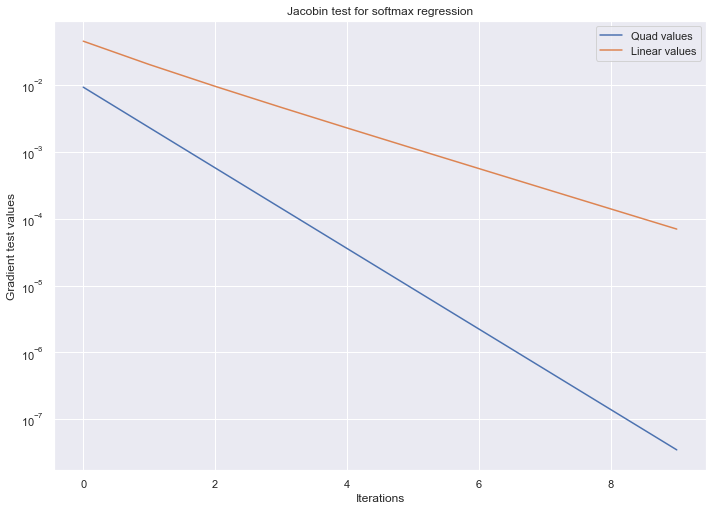

In [121]:

from IPython.core.display_functions import display

def gradient_test_demonstration():
    """
    Performs the gradient test and displays the data  , the first column is the value at each iteration and the second is the ration
    between two following iterations.
    :return:
    """
    values_quard,values_linear=gradient_test_softmax_reg()
    quad_graident_test=pd.DataFrame(data=[values_quard,values_quard[:-1]/values_quard[1:]]).T
    quad_graident_test.columns=["quadratic","F(i)/F(i+1)"]
    linear_gradient_test=pd.DataFrame(data=[values_linear,values_linear[:-1]/values_linear[1:]]).T
    linear_gradient_test.columns=["linear","F(i)/F(i+1)"]
    display(quad_graident_test)
    display(linear_gradient_test)
    plt.plot(values_quard,label="Quad values")
    plt.plot(values_linear,label="Linear values")

    plt.legend()
    plt.yscale("log")
    plt.title("Jacobin test for softmax regression")
    plt.ylabel("Gradient test values")
    plt.xlabel("Iterations")
    plt.show()
gradient_test_demonstration()

# Part I
## Question 2

Write the code for minimizing an objective function using SGD or some other SGD
variant (SGD with momentum, for example). Demonstrate and verify that your optimizer works on a small least squares example (add plots and submit the code itself).

We chose to implement 3 variation of SGD , the classic version , nestrov and moumentoum as seen in the following section



In [108]:
def SGD(x,y,w,loss_func,batch_size=16,lr=1e-5,beta=0.9,iters=50000,nestrov=False,mounemtoum=False):
    """
    An implementation of SGD with his variants , given data and weights he'll update the weight
    accordingly.
    :param x:
    :param y:
    :param w:
    :param loss_func:
    :param batch_size:
    :param lr:
    :param beta:
    :param iters:
    :param nestrov:
    :param mounemtoum:
    :return:
    """
    loss=[]
    prev_grad=0
    for i in range(iters):
        if nestrov:
            grad,val=loss_func(x,y,w-beta*prev_grad)
        else:
            grad,val=loss_func(x,y,w)

        if nestrov or mounemtoum:
            grad=beta*prev_grad+lr*grad
            prev_grad=grad
        else:
            grad=lr*grad

        w=w-grad
        loss.append(val)
    return w, loss


Small sample to verify  that it works

In [111]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

def loss_func_line_fitting(x,y,w):
    """
    giving noisy data and weights , we perform one iteration of their gradients and values for simple
    line fitting , i.e. we calculate the loss function and the gradient.
    :param x:
    :param y:
    :param w:
    :return:
    """
    a=w[0]
    b=w[1]
    val=np.square(a*x+b-y).mean()
    grad_a=(2*(a*x+b-y)*x).mean()
    grad_b=2*(a*x+b-y).mean()
    grad=np.array([grad_a,grad_b])
    return grad,val

def simple_line_fitting(to_plot=True):
    """
    A simple line fitting which includes the init of random data and weights , followed by
    their optimization using SGD with different variants.
    :param to_plot:
    :return:
    """
    w=np.random.random(2)
    x=np.arange(1,50)
    y=np.arange(1,50)+np.random.normal(size=49)*0.5
    if to_plot==True:
        sns.lineplot(x=x,y=y)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Noisy data for line fitting , sampeled from $x=y$ , guassain noise with $\sigma=0.5$")
        plt.show()

    w_n,loss_n=SGD(x,y,w,loss_func_line_fitting,lr=0.0001,nestrov=True)
    w_m,loss_m=SGD(x,y,w,loss_func_line_fitting,lr=0.0001,mounemtoum=True)
    w,loss=SGD(x,y,w,loss_func_line_fitting,lr=0.0001)

    if to_plot==True:
        a=w[0]
        b=w[1]
        print("SGD standart a = {} , b ={}".format(a,b))


        plt.plot(loss[:100])
        plt.title("Converges of the loss function")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.yscale("log")
        plt.show()
        y_hat=a*x+b
        plt.plot(x,y_hat,label="$\hat y=\hat ax+\hat b$")
        sns.lineplot(x=x,y=y,label="noisy sampel from y=x")
        sns.lineplot(x=x,y=np.arange(1,50),label="y=x")
        plt.xlabel("x")
        plt.ylabel("y")

    return w_n,w_m,w

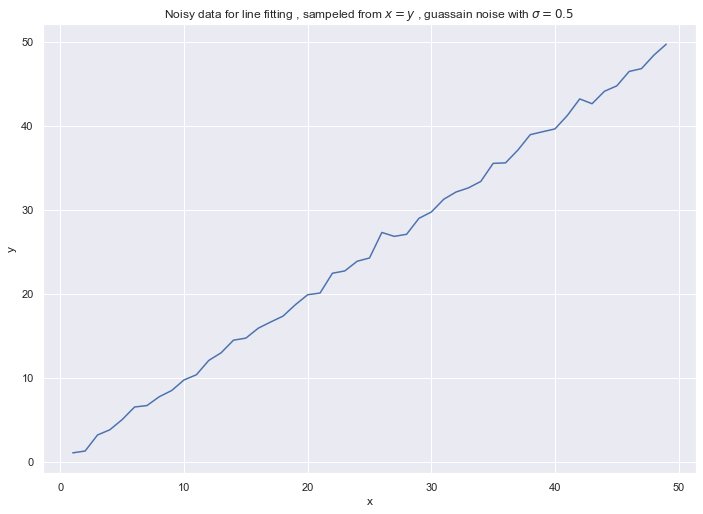

SGD standart a = 1.0067496501143596 , b =-0.17453831850205515


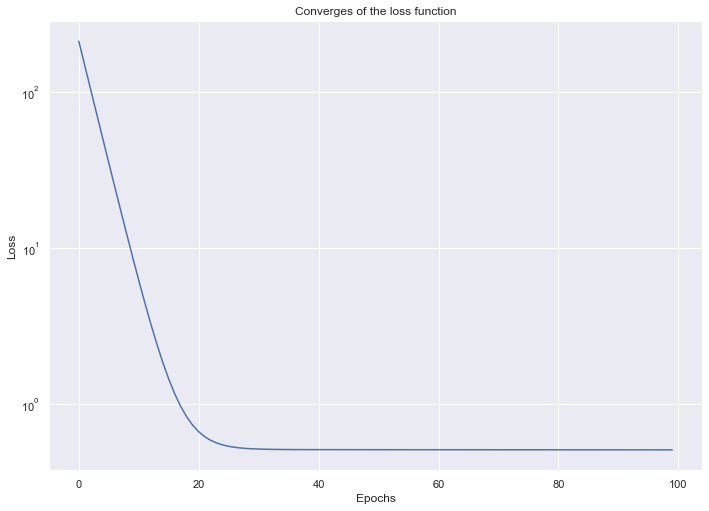

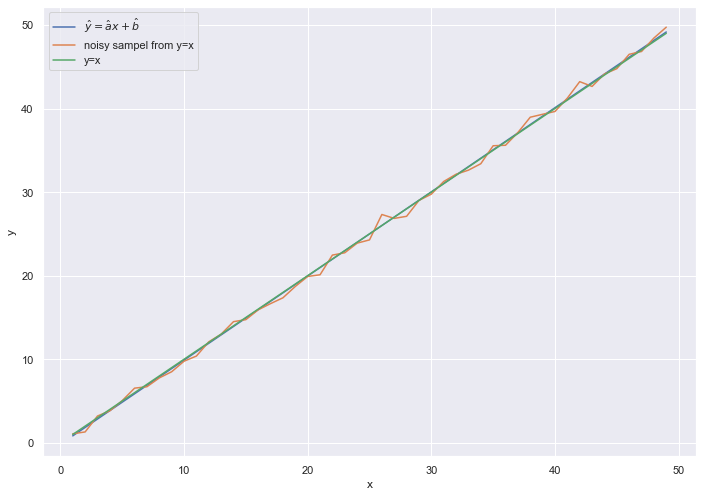

In [112]:
simple_line_fitting()
print("")

Comapring SGD variants for the least square example , beacuse we know the optimal parameters of a and b (a=1,b=0) its easy to
asses the competability of the SGD variation to the current problem.

In [17]:
def comapre_SGD_variants_line_fitting():
    """
    Comparing the learned weights of a and b to their optimal values (a=1,b=0) , by fitting a simple noisy line 30 times , 3 times for each variation.
    :return:
    """
    w_l=[]
    w_lm=[]
    w_ln=[]

    for i in range(10):
        #recieve weights for each simpe line fitting and save them
        w_n,w_m,w=simple_line_fitting(to_plot=False)
        w_l.append(w)
        w_lm.append(w_m)
        w_ln.append(w_n)

    wl=np.array(w_l)
    w_lm=np.array(w_lm)
    w_ln=np.array(w_ln)

    df_a=pd.DataFrame([wl[:,0],w_lm[:,0],w_ln[:,0]]).T
    df_a.columns=["a_hat SGD","a_hat SGD mounentuom"," a_hat SGD nesterov"]

    df_b=pd.DataFrame([wl[:,1],w_lm[:,1],w_ln[:,1]]).T
    df_b.columns=["b_hat SGD","b_hat SGD mounentuom"," b_hat SGD nesterov"]

    display(df_a)
    display(df_b)


comapre_SGD_variants_line_fitting()


,a_hat SGD,a_hat SGD mounentuom,a_hat SGD nesterov
0,1.000537,1.001957,1.001957
1,0.996107,0.998472,0.998472
2,0.996033,0.996625,0.996625
3,0.997485,0.997656,0.997656
4,1.002971,1.003958,1.003958
5,0.994313,0.995146,0.995146
6,0.995111,0.997015,0.997015
7,0.997278,0.999292,0.999292
8,1.002259,1.003421,1.003421
9,0.996964,0.997293,0.997293


,b_hat SGD,b_hat SGD mounentuom,b_hat SGD nesterov
0,0.017465,-0.029383,-0.029383
1,0.175874,0.097835,0.097835
2,-0.032174,-0.051706,-0.051706
3,0.146998,0.141375,0.141375
4,-0.027643,-0.060202,-0.060202
5,0.103172,0.075677,0.075677
6,0.112265,0.049452,0.049452
7,0.193069,0.126639,0.126639
8,-0.123447,-0.161764,-0.161764
9,0.265536,0.254691,0.254691


## Discussion SGD variants :
Each have their strengths and weaknesses , it seems that for the simple problem of line fitting there isn't much different at the converging values for
SGD with momentum or nesterov variant , but they do differ from SGD , managing to outperform or vice versa.


In [150]:
import scipy.io
mat = scipy.io.loadmat('PeaksData.mat')



## Part 1 Question 3 , Dataset  "Peaks"

In [151]:
y_train=mat["Ct"]
x_train=mat["Yt"]

y_val=mat["Cv"]
x_val=mat["Yv"]

# Adding bias since its regression
x_train=np.vstack([x_train,np.ones(25000)])
x_val=np.vstack([x_val,np.ones(6250)])



In [152]:

def getLoss1(x,y,w,val=False):
    """
    Loss for softmax regression with an option to return the predicted label
    :param x:
    :param y:
    :param w:
    :param val:
    :return:
    """
    x=x.T
    m = x.shape[0]
    y_mat=y.T
    scores = np.dot(x,w)
    prob = softmax(scores)
    loss = (-1 /m) * np.sum(np.sum(y_mat * np.log(prob)))
    grad = (-1/m)*np.dot(x.T,(y_mat - prob))
    if val==True:
        return np.argmax(prob,axis=1)
    return grad,loss



def SGD(x,y,w,loss_func,batch_size=16,lr=1e-5,beta=0.9,iters=50000,nestrov=False,mounemtoum=False):
    """
    Same implementation as SGD as before , but supports batch-sizes now by picking random indices in the
    dataset length.
    :param x:
    :param y:
    :param w:
    :param loss_func:
    :param batch_size:
    :param lr:
    :param beta: beta hyper parameter for moumountem
    :param iters:
    :param nestrov: flag
    :param mounemtoum: flag
    :return:
    """
    loss=[]
    prev_grad=0
    for i in range(iters):
        #Batch sampling
        indices=np.random.randint(0,25000,batch_size)
        if nestrov:
            grad,val=loss_func(x[:,indices],y[:,indices],w-beta*prev_grad)
        else:
            grad,val=loss_func(x[:,indices],y[:,indices],w)
        if nestrov or mounemtoum:

            grad=beta*prev_grad+lr*grad
            prev_grad=grad

        else:
            grad=lr*grad

        w=w-grad
        loss.append(val)
    return w, loss

def optimize_f2(x,y,loss_func,lr=0.001,nestrov=False,moumentoum=False,plot=True,batch_size=32,data_set_peaks=True):
    """
    Performs an optimzation of a given dataset using softmax regression , supports Peaks and GMM only.
    :param x:
    :param y:
    :param loss_func:
    :param lr:
    :param nestrov: flag for SGD variant
    :param moumentoum:  flag for SGD varaint
    :param plot: flag which indicate plotting
    :param batch_size:
    :param data_set_peaks:  flag to indicate which dataset
    :return:
    """
    if data_set_peaks:

        w=np.zeros([3,5])
    else:
        w=np.zeros([6,5])
    loss=[]
    acc_train=[]
    acc_val=[]
    for i in range(200):
        lr=lr*np.power(0.9,i)


        w,loss_curr=SGD(x,y,w,loss_func,lr=lr,iters=25000//batch_size,batch_size=batch_size,nestrov=nestrov,mounemtoum=moumentoum)

        samples=25000
        agreements = getLoss1(x, y, w, val=True) == np.argmax(y, axis=0)
        loss.append(np.array(getLoss1(x, y, w)[1]))

        acc_train.append(agreements.sum()/samples)

        samples=6250

        agreements = getLoss1(x_val, y_val ,w, val=True) == np.argmax(y_val, axis=0)
        acc_val.append(agreements.sum()/samples)

    if plot :
        plt.plot(acc_val,label="acc validation")
        plt.plot(acc_train,label="acc train")
        plt.legend()
        plt.title("Accuracy on Peaks data set , using SGD nestrov")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.show()

        plt.title("function loss on Peaks data set , using SGD nestrov")
        plt.xlabel("Epochs")
        plt.ylabel("loss")
        plt.plot(loss)
        plt.show()

    return w, loss , acc_val,acc_train

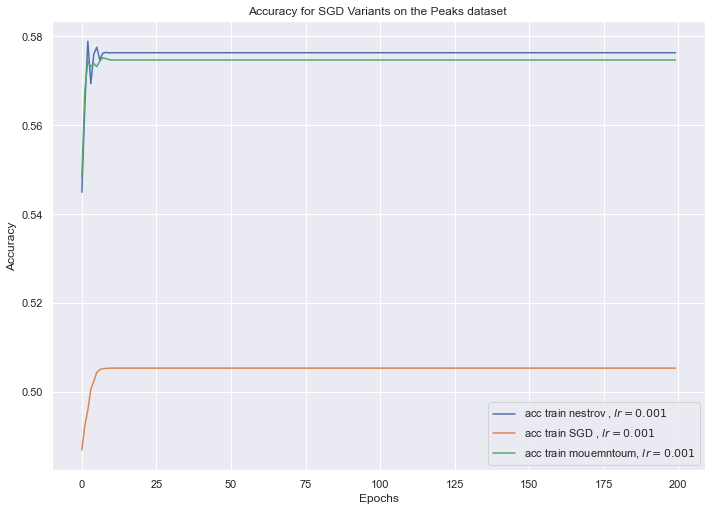

In [153]:
def comapre_sgd_variants(data_set_peaks=True):
    """
    Comapres different SGD varaints on a given dataset trained with softmax regression
    :param data_set_peaks:
    :return:
    """
    _,_,val_sgd,train_sgd=optimize_f2(x_train,y_train,getLoss1,plot=False,data_set_peaks=data_set_peaks)
    _,_,val_v,train_v=optimize_f2(x_train,y_train,getLoss1,nestrov=True,plot=False,data_set_peaks=data_set_peaks)
    _,_,val_m,train_m=optimize_f2(x_train,y_train,getLoss1,moumentoum=True,plot=False,data_set_peaks=data_set_peaks)


    if data_set_peaks:
        data_set="Peaks"
    else:
        data_set="GMM"
    plt.plot(train_v,label="acc train nestrov , $lr=0.001$")
    plt.plot(train_sgd,label="acc train SGD , $lr=0.001$")
    plt.plot(train_m,label="acc train mouemntoum, $lr=0.001$")
    plt.title(f"Accuracy for SGD Variants on the {data_set} dataset ")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
comapre_sgd_variants()

Preperation of the data for the GMM dataset , training using softmax regression.

In [154]:
mat=scipy.io.loadmat("GMMData.mat")

y_train=mat["Ct"]
x_train=mat["Yt"]

y_val=mat["Cv"]
x_val=mat["Yv"]

x_train=np.vstack([x_train,np.ones(25000)])
x_val=np.vstack([x_val,np.ones(6250)])




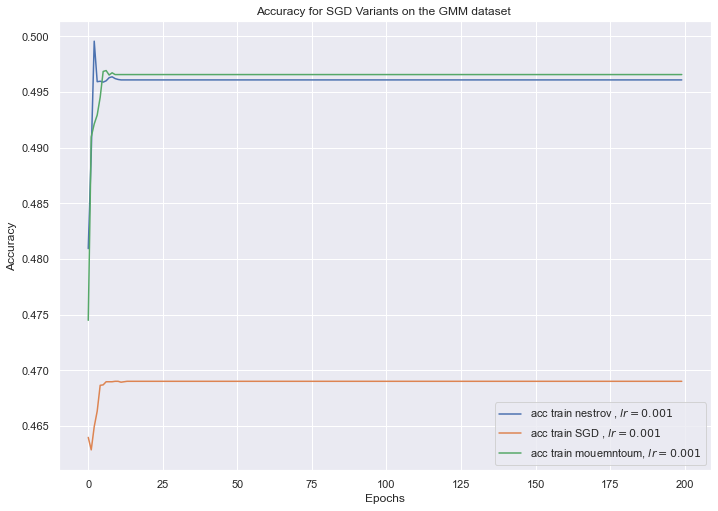

In [155]:
comapre_sgd_variants(data_set_peaks=False)



## Learning rate and batch sizes experiments for peaks dataset
Varying batch sizes still resulted an almost equal accuracy in convergence if we adujst the lr accordingly , but if the lr is constant and the batch sizes
are changing then there are differences. for example ,  if lr=0.001

for batchsize 16 we reach convergence with 53.6%
for batchsize 32 we reach convergence with 53.6%
for batchsize 128 we reach convergence with 51%
for batchsize 256 we reach convergence with 50%

but for lr =0.01 we converge with batch-size 256 to 53.6% , which make sense since we're averaging 256 samples which should grant us a good gradient , therefor we can use higher learning rate since we're more confident.


eventaully , we chose a batchsize of 32 and examined the following learning rates :

lr=0.1 , convergence to 58.6 and less stable (upper limit=0.59)
lr=0.01  convergence to 58.6 , stability (upper limit =0.545)
lr=0.001 ,  convergence to 58.6 and  stability (upper limit =0.586)
lr=0.0001 ,  convergence to 49.7  stability (upper limit =0.4975)

therefor learning rate impacts how the accuracy fluctuates around its around convergence , which could result in unstable learning. Learning rates that are
too low would hurt our performance. As learning rate decreases the stability of the training necessary increases but the accuracy changes and stagants if the lr is too low.

## GMM dataset
As we can see , the accuracy is lower at convergence , the added dimensions of the input heavily complicates the space we wish to learn , the peaks data set is a function
from $f:\mathbb{R}^{2}\rightarrow\mathbb{R}^{5}$ , but the GMM datasets increase the dimension of the input to 5 , i.e. $f:\mathbb{R}^{5}\rightarrow\mathbb{R}^{5}$ which explains the
different in accuracy.

# Part 2

The following section defines the forward and backwards of a standart feed forward network using tanh activation function.

In [7]:
import numpy as np

from copy import deepcopy

def ReLU(x):
    return x * (x > 0)

def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm

def forward_FFN(x, y, W, b, act_f):
    depth=len(W)
    hidden_layers=[x]
    hidden_layer=x
    for i in range(depth):
        if i!=depth-1:
            hidden_layer=act_f(hidden_layer@W[i]+b[i])
            hidden_layers.append(hidden_layer)
        else:
            #no act_f on the final layer
            hidden_layer =(hidden_layer @ W[i] + b[i])
            hidden_layers.append(hidden_layer)


    exp_scores = np.exp(deepcopy(hidden_layer))
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    loss = (-1/x.shape[0]) * np.sum(y * np.log(probs))
    return probs , hidden_layers ,loss




def backward_FFN(x, y, W, b):
    num_examples=x.shape[0]
    prob,hidden_layers,loss=forward_FFN(x, y, W, b, np.tanh)

    #derv of softmax
    dscores = deepcopy(prob)
    dscores[range(num_examples),np.argmax(y,axis=1)]-=1
    dscores /= num_examples
    depth=len(W)


    V=dscores


    dW_list=[]
    dB_list=[]
    dX_list=[V]
    curr_V=V
    for j in range(depth-1,-1,-1):
        curr_w=W[j]
        curr_layer=hidden_layers[j]
        dW=curr_layer.T@curr_V
        db=np.sum(curr_V,axis=0)
        dXn=curr_V@curr_w.T
        V=dXn


        if j!=0:
            dtanh = 1 - np.tanh(hidden_layers[j-1]@W[j-1]+b[j-1]) ** 2
            curr_V = dtanh * V


        dW_list.append(dW)
        dB_list.append(db)
        dX_list.append(curr_V)

    return dW_list[::-1],dB_list[::-1],dX_list[::-1]

import scipy.io
mat = scipy.io.loadmat('PeaksData.mat')


## Jacobain test feed foward network
We perform the jacobian test on a nerual network with 2 layer , the structure of the testes network is as follows:
$$softmax\left(W_{2}tanh\left(W_{1}x_{0}+b_{1}\right)+b_{2}\right)$$

thus , if the depth increases then the recurring part is the tanh layer , thus we perform a jacobian  test on that layer. The last layer , the softmax
and the loss function would be verified afterwards using the gradient test on the whole feed forward network.

## Part 2 Question 1
Jacboain test for feed forward

In [147]:

def Jacobian_test_feed_forward_NN():
    """
    The first part of the function defines random weights and biases , then we perform the jacobain test
    for the first layer in the network.
    :return:
    """
    values_linear=[]
    values_quard=[]
    epsilon=0.2
    #wieghts init
    w_orig=[np.random.random((5,20)),np.random.random((20,5))]
    b_orig=[np.random.random(20),np.random.random(5)]

    x=np.random.random((1,5))
    y=np.zeros((1,5))
    y[:,3]=1

    prob,layers,loss = forward_FFN(x, y,w_orig,b_orig,np.tanh)
    #random vectors init
    random_w1,random_w2=np.random.random((5,20)),np.random.random((20,5))
    random_w1=random_w1/np.linalg.norm(random_w1,ord=2)

    random_b1,random_b2=np.random.random(20),np.random.random(5)
    w=deepcopy(w_orig)
    b=deepcopy(b_orig)

    for i in range(20):
        eps = epsilon * (np.power(0.5, i))
        w[0]=w_orig[0]+random_w1*eps
        b[0]=b_orig[0]+random_b1*eps
        prob,layers_eps,loss=forward_FFN(x,y,w,b,np.tanh)

        #jacobain calculation for the first layer.
        derv_first_layer=1-np.tanh((x@w_orig[0])+b_orig[0])**2
        grad_w=x.T@derv_first_layer
        grad_b=(derv_first_layer*eps*random_b1).sum(axis=0)
        grad_mult_random_w=((grad_w*random_w1)*eps).sum(axis=0,keepdims=True)

        #quad values calcuation
        grad_test_quard = layers_eps[1] - layers[1] - grad_mult_random_w-grad_b
        val_linear = np.linalg.norm(layers_eps[1]-layers[1],ord=2)
        val_quad = np.linalg.norm(grad_test_quard, ord=2)
        values_linear.append(val_linear)
        values_quard.append(val_quad)

    values_quard=np.array(values_quard)
    values_linear=np.array(values_linear)

    return values_linear,values_quard

import seaborn as sns



The following section prints the results in two lists , the first column signifies the quadratic or linear  measurements and the second column displays the ration between
following  outputs , as we can see the ratio for the quadratic converges to 4 , while the linear convergences to 2 which proves that our Jacobian  is correct.

       quadratic  F(i)/F(i+1)
0   1.839252e-02     3.794304
1   4.847404e-03     3.894720
2   1.244609e-03     3.946777
3   3.153482e-04     3.973246
4   7.936791e-05     3.986588
5   1.990873e-05     3.993285
6   4.985551e-06     3.996641
7   1.247436e-06     3.998320
8   3.119899e-07     3.999160
9   7.801387e-08     3.999580
10  1.950552e-08     3.999790
11  4.876635e-09     3.999895
12  1.219191e-09     3.999948
13  3.048016e-10     3.999971
14  7.620095e-11     3.999994
15  1.905027e-11     4.000030
16  4.762532e-12     3.999889
17  1.190666e-12     4.000523
18  2.976276e-13     4.002611
19  7.435837e-14          NaN
          linear  F(i)/F(i+1)
0   1.012884e-01     1.844962
1   5.490000e-02     1.919358
2   2.860331e-02     1.958883
3   1.460185e-02     1.979241
4   7.377498e-03     1.989570
5   3.708086e-03     1.994773
6   1.858902e-03     1.997383
7   9.306686e-04     1.998691
8   4.656391e-04     1.999345
9   2.328958e-04     1.999673
10  1.164670e-04     1.999836
11  5.8238

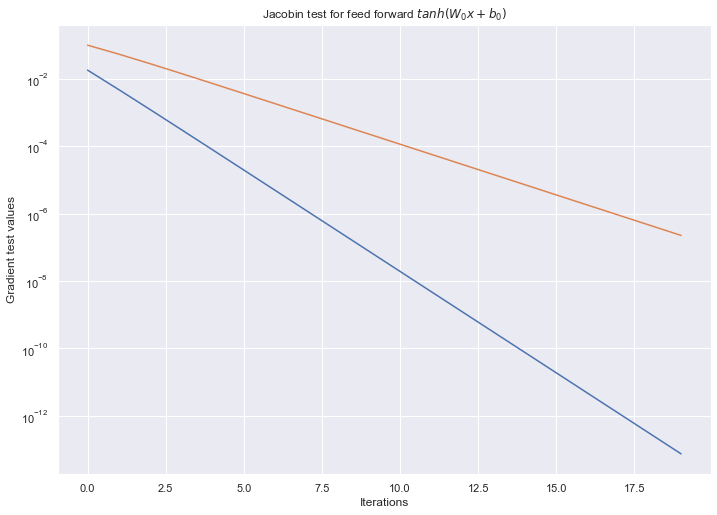

In [148]:


values_linear,values_quard=Jacobian_test_feed_forward_NN()
quad_graident_test=pd.DataFrame(data=[values_quard,values_quard[:-1]/values_quard[1:]]).T
quad_graident_test.columns=["quadratic","F(i)/F(i+1)"]
linear_gradient_test=pd.DataFrame(data=[values_linear,values_linear[:-1]/values_linear[1:]]).T
linear_gradient_test.columns=["linear","F(i)/F(i+1)"]

print(quad_graident_test)
print(linear_gradient_test)

plt.plot(values_quard)
plt.plot(values_linear)
plt.yscale("log")
plt.title("Jacobin test for feed forward $tanh(W_{0}x+b_{0})$")
plt.ylabel("Gradient test values")
plt.xlabel("Iterations")
plt.show()


## Part 2 Question 2

Forward and backwards ResNet

In [5]:

def RNN_forward(x,y,W,b,act_f):
    depth=len(W)
    hidden_layers=[x]
    hidden_layer=x.T
    hidden_tanh=[]
    hidden_relu=[]
    for i in range(depth):
        #Forward caclulation of ReLU(w1x+tanh(w2x+b1)+b2)
        hidden_layer_1 = W[i][0] @ hidden_layer + b[i][0].reshape(-1,1)
        hidden_tanh.append(W[i][0] @ hidden_layer + b[i][0].reshape(-1,1))
        hidden_relu.append((W[i][1]@ hidden_layer + (act_f(hidden_layer_1)) + b[i][1].reshape(-1,1)))
        hidden_layer= ReLU((W[i][1]@ hidden_layer + (act_f(hidden_layer_1)) + b[i][1].reshape(-1,1)))
        hidden_layers.append(hidden_layer.T)

    exp_scores = np.exp(deepcopy(((hidden_layer.T))))
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    loss = (-1/x.shape[0]) * np.sum(y* np.log(probs))
    return probs , hidden_layers ,loss,hidden_relu,hidden_tanh


def backward_rnn(x,y,W,b):
    num_examples=x.shape[0]
    prob,hidden_layers,loss,hidden_relu,hidden_tanh=RNN_forward(x,y,W,b,np.tanh)

    dscores = deepcopy(prob)
    dscores[range(num_examples),np.argmax(y,axis=1)]-=1
    dscores /= num_examples
    depth=len(W)
    V=dscores

    dW_list=[]
    dB_list=[]
    dX_list=[]

    for j in range(depth-1,-1,-1):
        w1=W[j][0]
        w2=W[j][1]
        b1=b[j][0]
        b2=b[j][1]

        drelu=hidden_relu[j].T

        drelu[drelu<0]=0
        drelu[drelu>0]=1

        V = drelu * V
        X=hidden_layers[j]
        w_outer=(X.T@V).T
        db_outer=np.sum(V,axis=0)
        dhidden=w1 @ X.T + b1.reshape(-1,1)
        dhidden=1-np.tanh(dhidden)*np.tanh(dhidden)

        dXn= V@w2 + (dhidden.T*V)@w1

        w_inner=  ((V.T*dhidden)@ X)

        db_inner= (dhidden *V.T).sum(axis=1)

        V=dXn
        dW_list.append([w_inner,w_outer])
        dB_list.append([db_inner,db_outer])
        dX_list.append(dXn)

    return dW_list[::-1],dB_list[::-1],dX_list[::-1]


## Jacobin test for ResNet

Results as shown as a table , one for the quadratic and one for the linear as in previous examples.

       quadratic  F(i)/F(i+1)
0   2.291354e-02     3.394476
1   6.750244e-03     3.654941
2   1.846882e-03     3.814575
3   4.841644e-04     3.903693
4   1.240273e-04     3.950895
5   3.139221e-05     3.975202
6   7.897008e-06     3.987539
7   1.980422e-06     3.993754
8   4.958797e-07     3.996873
9   1.240669e-07     3.998436
10  3.102887e-08     3.999217
11  7.758735e-09     3.999609
12  1.939873e-09     3.999804
13  4.849921e-10     3.999902
14  1.212510e-10     3.999950
15  3.031313e-11     3.999999
16  7.578284e-12     3.999954
17  1.894593e-12     3.999963
18  4.736526e-13     4.002315
19  1.183447e-13          NaN
          linear  F(i)/F(i+1)
0   3.806945e-02     1.607284
1   2.368558e-02     1.774717
2   1.334611e-02     1.878673
3   7.104010e-03     1.936937
4   3.667651e-03     1.967836
5   1.863799e-03     1.983756
6   9.395304e-04     1.991837
7   4.716905e-04     1.995908
8   2.363288e-04     1.997951
9   1.182855e-04     1.998975
10  5.917309e-05     1.999487
11  2.9594

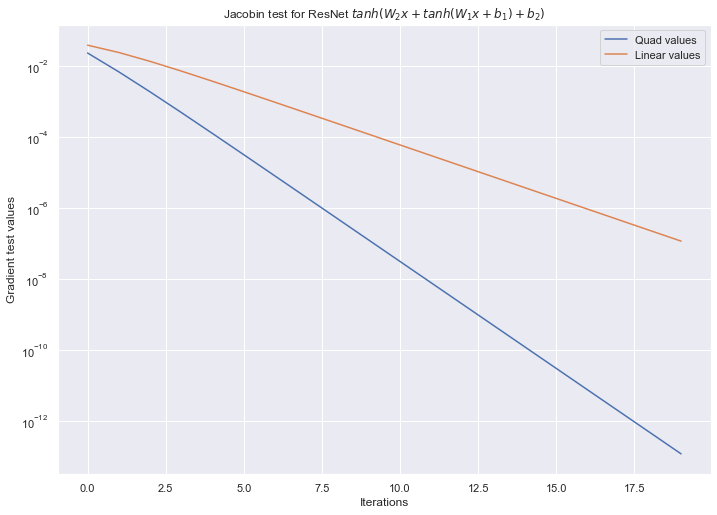

In [130]:



def init_weights_forward_ResNet(depth,WIDTH_NET,ORDER_NORM,NUM_CLASSES,INPUT_LEN):

    w=[[np.random.random((WIDTH_NET, INPUT_LEN))/ORDER_NORM,np.random.random((WIDTH_NET, INPUT_LEN))/ORDER_NORM]]
    for i in range(depth-2):
        w.append([np.random.random((WIDTH_NET, WIDTH_NET)) / ORDER_NORM, np.random.random((WIDTH_NET, WIDTH_NET))/ORDER_NORM])
    w.append([np.random.random((NUM_CLASSES,WIDTH_NET))/ORDER_NORM,np.random.random((NUM_CLASSES,WIDTH_NET))/ORDER_NORM])


    b=[[np.random.random(WIDTH_NET)/ORDER_NORM,np.random.random(WIDTH_NET)/ORDER_NORM]]
    for i in range(depth-2):
        b.append([np.random.random(WIDTH_NET)/ORDER_NORM,np.random.random(WIDTH_NET)/ORDER_NORM])
    b.append([np.random.random(NUM_CLASSES) / ORDER_NORM,np.random.random(NUM_CLASSES) / ORDER_NORM])
    return w,b


def Jacobian_test_ResNet():
    """
    The first part of the function defines random weights and biases , then we perform the jacobain test
    for the first layer in the network.
    :return:
    """
    values_linear=[]
    values_quard=[]
    epsilon=0.2


    #initilziaotn of weights for the resnet network
    w_orig,b_orig=init_weights_forward_ResNet(2,WIDTH_NET=20,ORDER_NORM=1,NUM_CLASSES=5,INPUT_LEN=5)

    x=np.random.random((1,5))
    y=np.zeros((1,5))
    y[:,3]=0

    # init of random vectors
    random_w00,random_w01=np.random.random((20,5)),np.random.random((20,5))
    random_b1,random_b2=np.random.random(20),np.random.random(20)
    w=deepcopy(w_orig)
    b=deepcopy(b_orig)


    #hand calculation of the resnet layer
    x=x.T
    starting_layer=(w[0][0]@x+b[0][0].reshape(-1,1))
    middle_layer=w[0][1]@x+np.tanh(w[0][0]@x+b[0][0].reshape(-1,1))+b[0][1].reshape(-1,1)
    final_layer=np.tanh(w[0][1]@x+np.tanh(w[0][0]@x+b[0][0].reshape(-1,1))+b[0][1].reshape(-1,1))

    #derv of tanh
    outer_derv=1-np.tanh(middle_layer)**2

    #derv of w1
    w01_grad=x@outer_derv.T
    w01_grad=w01_grad.T


    inner_derv=1-np.tanh(starting_layer)**2

    V=inner_derv*outer_derv

    #derv of w0
    w00_derv=x@V.T
    w00_derv=w00_derv.T

    # calcuation of the biases gradients
    b2_derv=outer_derv.sum(axis=1,keepdims=True)
    b1_derv=V.sum(axis=1,keepdims=True)

    b2_derv=b2_derv.T
    b1_derv=b1_derv.T


    for i in range(20):
        eps = epsilon * (np.power(0.5, i))
        w[0][1]=w_orig[0][1]+random_w01*eps
        w[0][0]=w_orig[0][0]+random_w00*eps
        b[0][1]=b_orig[0][1]+random_b2*eps
        b[0][0]=b_orig[0][0]+random_b1*eps
        #jacobain calculation for the first layer.


        final_layer_moved=np.tanh(w[0][1]@x+np.tanh(w[0][0]@x+b[0][0].reshape(-1,1))+b[0][1].reshape(-1,1))
        grad_w1 = (w01_grad * random_w01 * eps).sum(axis=1, keepdims=True)
        grad_w0 = (w00_derv * random_w00 * eps).sum(axis=1, keepdims=True)

        grad_b2 = b2_derv * random_b2 * eps
        grad_b1=b1_derv*random_b1*eps


        grad_test_quard = final_layer_moved - final_layer - grad_w1 - grad_w0 - grad_b2.T-grad_b1.T
        val_linear = np.linalg.norm(final_layer_moved-final_layer,ord=2)
        val_quad = np.linalg.norm(grad_test_quard, ord=2)
        values_linear.append(val_linear)
        values_quard.append(val_quad)

    values_quard=np.array(values_quard)
    values_linear=np.array(values_linear)

    return values_linear,values_quard


values_linear,values_quard=Jacobian_test_ResNet()
quad_graident_test=pd.DataFrame(data=[values_quard,values_quard[:-1]/values_quard[1:]]).T
quad_graident_test.columns=["quadratic","F(i)/F(i+1)"]
linear_gradient_test=pd.DataFrame(data=[values_linear,values_linear[:-1]/values_linear[1:]]).T
linear_gradient_test.columns=["linear","F(i)/F(i+1)"]
print(quad_graident_test)
print(linear_gradient_test)
plt.plot(values_quard,label="Quad values")
plt.plot(values_linear,label="Linear values")

plt.legend()
plt.yscale("log")
plt.title("Jacobin test for ResNet $tanh(W_2x+tanh(W_1x+b_1)+b_2)$")
plt.ylabel("Gradient test values")
plt.xlabel("Iterations")
plt.show()

In [39]:

import scipy.io
mat = scipy.io.loadmat('PeaksData.mat')

y=mat["Ct"].T
x=mat["Yt"].T
x=x[:1,:]
y=y[:1,:]

def grad_test_whole_network():
    values_linear=[]
    values_quard=[]

    NUM_CLASSES = 5
    INPUT_LEN=2
    WIDTH_NET = 50

    # Init random weights
    w1= np.random.random((INPUT_LEN, WIDTH_NET))

    w4= np.random.random((WIDTH_NET, NUM_CLASSES))
    b1= np.random.random(WIDTH_NET)

    b4= np.random.random(NUM_CLASSES)

    w=[w1,w4]
    b=[b1,b4]
    #init random vectors
    w1_random=np.random.random((INPUT_LEN,WIDTH_NET ))
    w1_random= w1_random/np.linalg.norm(w1_random,ord=2)

    w2_random=np.random.random((WIDTH_NET,NUM_CLASSES))
    w2_random= w2_random/np.linalg.norm(w2_random,ord=2)

    b1_random=np.random.random(WIDTH_NET)
    b1_random= b1_random/np.linalg.norm(b1_random,ord=2)

    b2_random=np.random.random(NUM_CLASSES)
    b2_random=b2_random/np.linalg.norm(b2_random,ord=2)

    probs,_,loss=forward_FFN(x,y,w,b,np.tanh)

    dw,db,dX=backward_FFN(x,y,w,b)
    eps=0.3
    w_test=deepcopy(w)
    b_test=deepcopy(b)
    for i in range(10):
        #add random vectors to weights
        epsilom = eps * (np.power(0.5, i))
        w_test[0]=w[0]+w1_random*epsilom
        w_test[1]=w[1]+w2_random*epsilom
        b_test[0]=b[0]+b1_random*epsilom
        b_test[1]=b[1]+b2_random*epsilom

        # grad summation of the final values for the grad test in the quad values
        grad=(dw[0]*w1_random*epsilom).sum()+(dw[1]*w2_random*epsilom).sum()+(db[0]*b1_random*epsilom).sum()+(db[1]*b2_random*epsilom).sum()

        probs,_,loss_moved=forward_FFN(x,y,w_test,b_test,np.tanh)
        val_linear = np.abs(loss_moved-loss)
        val_quad = np.abs(loss_moved- loss - grad)

        values_linear.append(val_linear)
        values_quard.append(val_quad)


    values_quard=np.array(values_quard)
    values_linear=np.array(values_linear)
    return values_quard,values_linear

values_quard,values_linear=grad_test_whole_network()
quad_graident_test=pd.DataFrame(data=[values_quard,values_quard[:-1]/values_quard[1:]]).T
quad_graident_test.columns=["quadratic","F(i)/F(i+1)"]
linear_gradient_test=pd.DataFrame(data=[values_linear,values_linear[:-1]/values_linear[1:]]).T
linear_gradient_test.columns=["linear","F(i)/F(i+1)"]
display(quad_graident_test)
display(linear_gradient_test)

,quadratic,F(i)/F(i+1)
0,1.479319e-03,3.817278
1,3.875326e-04,3.914214
2,9.900648e-05,3.958446
3,2.501145e-05,3.979551
4,6.284992e-06,3.989857
5,1.575242e-06,3.994949
6,3.943086e-07,3.997479
7,9.863930e-08,3.998741
8,2.466759e-08,3.999371
9,6.167868e-09,NaN


,linear,F(i)/F(i+1)
0,0.165942,2.008524
1,0.082619,2.004598
2,0.041215,2.002380
3,0.020583,2.001210
4,0.010285,2.000610
5,0.005141,2.000306
6,0.002570,2.000153
7,0.001285,2.000077
8,0.000642,2.000038
9,0.000321,NaN


## Part 2 , Question 3 , Gradient test feed forward

,quadratic,F(i)/F(i+1)
0,8.002958e-03,4.055892
1,1.973168e-03,4.028968
2,4.897454e-04,4.014711
3,1.219877e-04,4.007408
4,3.044055e-05,4.003717
5,7.603072e-06,4.001862
6,1.899884e-06,4.000932
7,4.748604e-07,4.000466
8,1.187013e-07,4.000233
9,2.967359e-08,NaN


,linear,F(i)/F(i+1)
0,0.096207,2.088044
1,0.046075,2.044084
2,0.022541,2.022047
3,0.011147,2.011024
4,0.005543,2.005512
5,0.002764,2.002756
6,0.001380,2.001378
7,0.000690,2.000689
8,0.000345,2.000344
9,0.000172,NaN


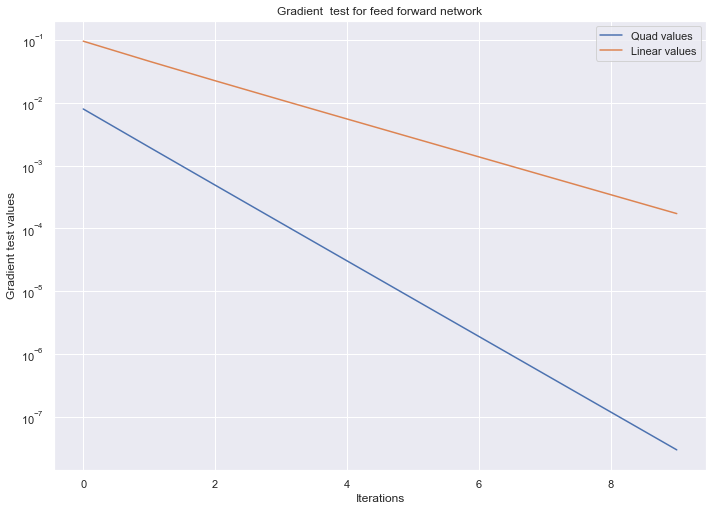

In [132]:
import scipy.io
mat = scipy.io.loadmat('PeaksData.mat')

y=mat["Ct"].T
x=mat["Yt"].T
x=x[:1,:]
y=y[:1,:]
import numpy as np
def grad_test_whole_network():
    values_linear=[]
    values_quard=[]

    NUM_CLASSES = 5
    INPUT_LEN=2
    WIDTH_NET = 50

    #init weights for the netowkr

    w1= np.random.random((INPUT_LEN, WIDTH_NET))

    w4= np.random.random((WIDTH_NET, NUM_CLASSES))
    b1= np.random.random(WIDTH_NET)

    b4= np.random.random(NUM_CLASSES)

    w=[w1,w4]
    b=[b1,b4]
    #init random vectors
    w1_random=np.random.random((INPUT_LEN,WIDTH_NET ))
    w1_random= w1_random/np.linalg.norm(w1_random,ord=2)

    w2_random=np.random.random((WIDTH_NET,NUM_CLASSES))
    w2_random= w2_random/np.linalg.norm(w2_random,ord=2)

    b1_random=np.random.random(WIDTH_NET)
    b1_random= b1_random/np.linalg.norm(b1_random,ord=2)

    b2_random=np.random.random(NUM_CLASSES)
    b2_random=b2_random/np.linalg.norm(b2_random,ord=2)


    probs,_,loss=forward_FFN(x,y,w,b,np.tanh)

    dw,db,dX=backward_FFN(x,y,w,b)
    eps=0.3
    w_test=deepcopy(w)
    b_test=deepcopy(b)
    for i in range(10):
        #add random vectors to the weights t
        epsilom = eps * (np.power(0.5, i))
        w_test[0]=w[0]+w1_random*epsilom
        w_test[1]=w[1]+w2_random*epsilom
        b_test[0]=b[0]+b1_random*epsilom
        b_test[1]=b[1]+b2_random*epsilom

        #final values of the gradient for the grad test
        grad=(dw[0]*w1_random*epsilom).sum()+(dw[1]*w2_random*epsilom).sum()+(db[0]*b1_random*epsilom).sum()+(db[1]*b2_random*epsilom).sum()

        probs,_,loss_moved=forward_FFN(x,y,w_test,b_test,np.tanh)
        val_linear = np.abs(loss_moved-loss)
        val_quad = np.abs(loss_moved- loss - grad)

        values_linear.append(val_linear)
        values_quard.append(val_quad)


    values_quard=np.array(values_quard)
    values_linear=np.array(values_linear)
    return values_quard,values_linear

values_quard,values_linear=grad_test_whole_network()
quad_graident_test=pd.DataFrame(data=[values_quard,values_quard[:-1]/values_quard[1:]]).T
quad_graident_test.columns=["quadratic","F(i)/F(i+1)"]
linear_gradient_test=pd.DataFrame(data=[values_linear,values_linear[:-1]/values_linear[1:]]).T
linear_gradient_test.columns=["linear","F(i)/F(i+1)"]
display(quad_graident_test)
display(linear_gradient_test)

plt.plot(values_quard,label="Quad values")
plt.plot(values_linear,label="Linear values")

plt.legend()
plt.yscale("log")
plt.title("Gradient  test for feed forward network")
plt.ylabel("Gradient test values")
plt.xlabel("Iterations")
plt.show()

## Part 2 Question 3 , Gradient test ResNet

,quadratic,F(i)/F(i+1)
0,1.384215e-02,9.490286
1,1.458560e-03,3.294475
2,4.427289e-04,4.004528
3,1.105571e-04,4.002310
4,2.762331e-05,4.001167
5,6.903815e-06,4.000586
6,1.725701e-06,4.000294
7,4.313935e-07,4.000147
8,1.078444e-07,4.000073
9,2.696061e-08,NaN


,linear,F(i)/F(i+1)
0,0.122617,1.836380
1,0.066771,1.982980
2,0.033672,1.986923
3,0.016947,1.993494
4,0.008501,1.996755
5,0.004257,1.998379
6,0.002130,1.999190
7,0.001066,1.999595
8,0.000533,1.999798
9,0.000266,NaN


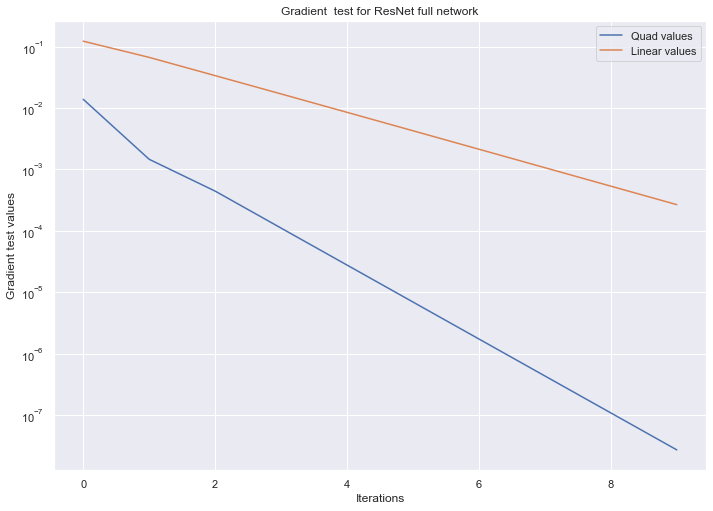

In [135]:
mat = scipy.io.loadmat('PeaksData.mat')
y=mat["Ct"].T
x=mat["Yt"].T
x=x[:1,:]
y=y[:1,:]
def grad_test_whole_network():
    values_linear=[]
    values_quard=[]


    NUM_CLASSES = 5
    INPUT_LEN=2
    WIDTH_NET = 100
    SCALE=1

    #init of random weights for the network
    w00 = np.random.random((WIDTH_NET, INPUT_LEN))/SCALE
    w01 = np.random.random((WIDTH_NET, INPUT_LEN))/SCALE
    w10 = np.random.random(( NUM_CLASSES,WIDTH_NET))/SCALE
    w11 = np.random.random((NUM_CLASSES,WIDTH_NET))/SCALE
    b00 = np.random.random(WIDTH_NET)/SCALE
    b01 = np.random.random(WIDTH_NET)/SCALE
    b10 = np.random.random(NUM_CLASSES)/SCALE
    b11 = np.random.random(NUM_CLASSES)/SCALE

    w = [[w00, w01],[w10,w11]]
    b = [[b00, b01],[b10,b11]]

    #init of random vectors to add to the weights
    w00_random=np.random.random((WIDTH_NET,INPUT_LEN ))
    w00_random= w00_random/np.linalg.norm(w00_random,ord=2)

    w01_random=np.random.random((WIDTH_NET,INPUT_LEN))
    w01_random= w01_random/np.linalg.norm(w01_random,ord=2)

    w10_random=np.random.random((NUM_CLASSES,WIDTH_NET))
    w10_random= w10_random/np.linalg.norm(w10_random,ord=2)

    w11_random=np.random.random((NUM_CLASSES,WIDTH_NET))
    w11_random= w11_random/np.linalg.norm(w11_random,ord=2)

    b00_random=np.random.random(WIDTH_NET)
    b00_random= b00_random/np.linalg.norm(b00_random,ord=2)

    b01_random=np.random.random(WIDTH_NET)
    b01_random= b01_random/np.linalg.norm(b01_random,ord=2)

    b10_random=np.random.random(NUM_CLASSES)
    b10_random= b10_random/np.linalg.norm(b10_random,ord=2)

    b11_random=np.random.random(NUM_CLASSES)
    b11_random= b11_random/np.linalg.norm(b11_random,ord=2)



    probs,_,loss,_,_=RNN_forward(x,y,w,b,np.tanh)

    dw,db,dX=backward_rnn(x,y,w,b)
    eps=0.3
    w_test=deepcopy(w)
    b_test=deepcopy(b)
    for i in range(10):
        epsilon = eps * (np.power(0.5, i))

        #adding the random vectors to the weights accordinly
        w_test[1][1]=w[1][1]+w11_random*epsilon
        w_test[1][0]=w[1][0]+w10_random*epsilon
        w_test[0][1]=w[0][1]+w01_random*epsilon
        w_test[0][0]=w[0][0]+w00_random*epsilon

        b_test[1][1]=b[1][1]+b11_random*epsilon
        b_test[1][0]=b[1][0]+b10_random*epsilon
        b_test[0][1]=b[0][1]+b01_random*epsilon
        b_test[0][0]=b[0][0]+b00_random*epsilon


        #calculation of the gradient per layer n their summation with regard to b and w
        grad_w=(dw[1][1]*w11_random*epsilon).sum()+(dw[0][0]*w00_random*epsilon).sum()+(dw[0][1]*w01_random*epsilon).sum()+(dw[1][0]*w10_random*epsilon).sum()
        grad_b=(db[1][1]*b11_random*epsilon).sum()+(db[0][0]*b00_random*epsilon).sum()+(db[0][1]*b01_random*epsilon).sum()+(db[1][0]*b10_random*epsilon).sum()
        grad=grad_b+grad_w

        probs,_,loss_moved,_,_=RNN_forward(x,y,w_test,b_test,np.tanh)
        val_linear = np.abs(loss_moved-loss)
        val_quad = np.abs(loss_moved- loss - grad)

        values_linear.append(val_linear)
        values_quard.append(val_quad)


    values_quard=np.array(values_quard)
    values_linear=np.array(values_linear)
    return values_quard,values_linear

values_quard,values_linear=grad_test_whole_network()
quad_graident_test=pd.DataFrame(data=[values_quard,values_quard[:-1]/values_quard[1:]]).T
quad_graident_test.columns=["quadratic","F(i)/F(i+1)"]
linear_gradient_test=pd.DataFrame(data=[values_linear,values_linear[:-1]/values_linear[1:]]).T
linear_gradient_test.columns=["linear","F(i)/F(i+1)"]
display(quad_graident_test)
display(linear_gradient_test)

plt.plot(values_quard,label="Quad values")
plt.plot(values_linear,label="Linear values")
plt.legend()
plt.yscale("log")
plt.title("Gradient  test for ResNet full network")
plt.ylabel("Gradient test values")
plt.xlabel("Iterations")
plt.show()

## Part 2  Question 4 , optimzation of feed forward nerual network on Peaks dataset
After verifying we perform a simple optimization of the neural network using the given datasets , peaks and GMM.

In [141]:



import matplotlib.pyplot as plt

def init_weights_forward_NN(depth,WIDTH_NET,ORDER_NORM,NUM_CLASSES,INPUT_LEN):

    # init w matrices
    w1= np.random.random((INPUT_LEN, WIDTH_NET)) / ORDER_NORM
    w=[w1]
    for i in range(depth-2):
        w.append(np.random.random((WIDTH_NET, WIDTH_NET)) / ORDER_NORM)
    w.append(np.random.random((WIDTH_NET, NUM_CLASSES)) / ORDER_NORM)

    print(f"the amount of layers is {len(w)}")

    #init biases
    b1= np.random.random(WIDTH_NET) / ORDER_NORM
    b=[b1]
    for i in range(depth-2):
        b.append(np.random.random(WIDTH_NET) / ORDER_NORM)
    b.append(np.random.random(NUM_CLASSES) / ORDER_NORM)
    return w,b






def optimize_NN(x,y,x_val,y_val,depth=4,lr=0.01,plot=True,batch_size=16,data_set="Peaks",iters=150,net_width=50):
    WIDTH_NET = net_width
    # init network sizes based on dataset
    if data_set=="Peaks":
        ORDER_NORM = 1
        NUM_CLASSES = 5
        INPUT_LEN=2
    if data_set=="GMM":
        ORDER_NORM = 1
        NUM_CLASSES = 5
        INPUT_LEN=5



    w,b=init_weights_forward_NN(depth=depth,WIDTH_NET=WIDTH_NET,ORDER_NORM=ORDER_NORM,NUM_CLASSES=NUM_CLASSES,INPUT_LEN=INPUT_LEN)


    loss_train=[]
    loss_val=[]
    acc_train=[]
    acc_val=[]
    train_size = 25000
    val_size=6250
    #each iter is an epoch
    for i in range(iters):
        curr_lr=np.power(0.99,i)*lr
        #each loop is per batch with weights update
        for j in range(train_size // batch_size):
            indices=np.random.randint(0, train_size, batch_size)
            dw,db,dx=backward_FFN(x[indices, :], y[indices, :], w, b)

            for i in range(len(w)):
                b[i]=b[i]-curr_lr*db[i]
                w[i]=w[i]-curr_lr*dw[i]


        #calc accuracy on train
        probs, hl, loss = forward_FFN(x[:, :], y[:, :], w, b, np.tanh)
        agreements = np.argmax(probs, axis=1) == np.argmax(y[:, :], axis=1)
        acc_train.append(agreements.sum() / train_size)
        loss_train.append(loss)

        #calc accuracy on val
        probs, hl, loss = forward_FFN(x_val[:, :], y_val[:, :], w, b, np.tanh)
        agreements = np.argmax(probs, axis=1) == np.argmax(y_val[:, :], axis=1)
        acc_val.append(agreements.sum() / val_size)
        loss_val.append(loss)




    if plot:
        plt.plot(acc_train, label="acc train")
        plt.plot(acc_val,label="acc val")
        plt.legend()
        plt.title(f"Accuracy on {data_set} data set , using SGD")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        print(f"Final accuracy on train is {acc_train[-1]}")
        print(f"Final accuracy on val is {acc_val[-1]}")
        plt.show()

        plt.plot(loss_train, label="loss train")
        plt.plot(loss_val,label="loss val")
        plt.legend()
        plt.title("Loss on Peaks data set , using SGD")
        plt.yscale("log")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show()

        plt.show()
    return w, loss , acc_val,acc_train


the amount of layers is 4
Final accuracy on train is 0.93476
Final accuracy on val is 0.93232


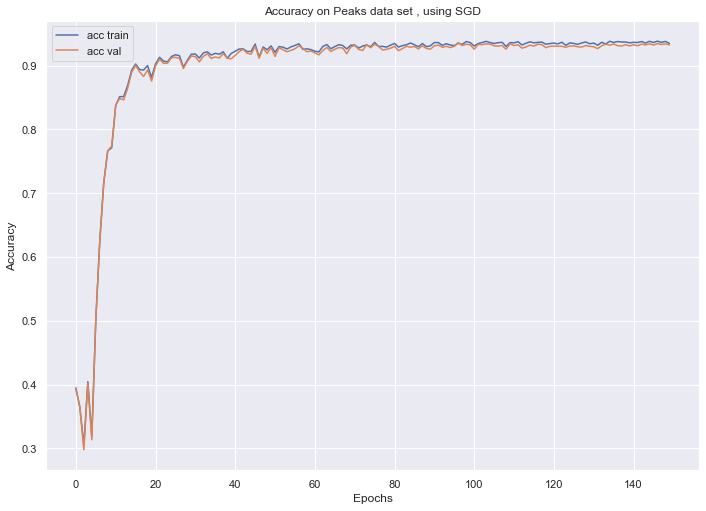

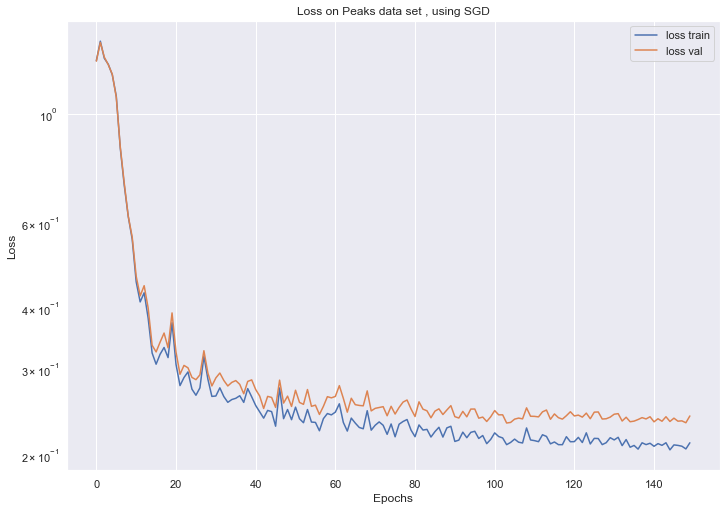

In [142]:

import scipy.io


mat=scipy.io.loadmat("PeaksData.mat")

y=mat["Ct"]
x=mat["Yt"]

y_val=mat["Cv"]
x_val=mat["Yv"]


optimize_NN(x.T,y.T,x_val.T,y_val.T,depth=4,lr=0.1,batch_size=16,net_width=50,iters=150)
print("")

# Experiments and failures network design  :

We spent alot of time trying to handle vanishing or exploding gradient , during the model arch process we had a hard time understading why the model didn't learn. The problem after debugging was either saturation of the model due to tanh sending all the values to 1 or minus 1 beacuse the wieghts are too big , or beacuse ReLU exploded the gradient. We were unaware of the start that exploding graidnet was the case and though perhaps the learning rate was too big , or maybe the batch-size. At start we tried to lower the size of the weights to enchance stability , but after a certain epoch , for each learning we choose , we either stopped progressing at all because he decreased too much , or the loss starting to increase and accuracy decreased.

 Therefor we had to try different combination of tanh and relu in order to maintain stability , we tried to make tanh encapsulate the layer and ReLU serve as an activation layer for the middle step in the RNN network but the graident still exploded , after debugging we realized which part of the network tends to explode and applied tanh there , which helped the stability of the netowrk and finally learning could begin.

# Hyper parameter searching Peaks data :
After finding a configuration which doesn't explode the gradient or vanishes it , we explore the hyper parameters of learning rate , batch-size and training time and depth.

## Depth  and epochs:
First , the width of the network is 50
We expect to see an increase in accuracy as the depth increases until a certain point , for a network with 2 layers we achieved 92.125 accuracy on train and 92.075 in convergence , which we reached after 50 iteration ,   in a forward NN with 4 layers 150 iterations were enough for convergence , which peaked at 93.2% for train and 93% for test.
we chose the depth to be 4 epochs amount to be 150.
## Learning rate :
Until now we used a LR of 0.01 , this section will expeirment with different learning rates.
### LR=0.001
A smaller learning rate would converge more slowly but could increase the final accuracy , thus we expiremented with 0.01 and 0.001 , first we checked the convergnce point for 0.01 and then observed if 250 iters are enough to acheieve convergence for a smaller learning rate , in the first attemtp the accuracy plummeted to 40% in convergence , we assumed because we were stuck in a local minima and perhaps the initizlation was unfrountane , thus we  ran the learning procdure a few times and achieved the same results, therefor we understood that for a depth of 4 a lr smaller then 0.01 isn't benefical to learning.
### LR=0.1
The next logical step is observing higher learning rate , for a learning of 0.1 the learning procedure occured as expected ,  and the achieved accuracy increased  , after 150 epochs we reached 93.7% for train and 93.2% for the test. This learning rate seems to converge faster and attain higher acc so we chose him.
Remark : We're using a decaying learning rate of $(0.99)^{epoch}*lr$


## Batch Size :
Until now we used a batchsize of 16 ,
We'll attemtp to see the accuracy for 8 , 16 , 32 batchsize , after 150 epochs using network width=50 , lr=0.1 , depth=4



### Batch-size == 8  :
Final accuracy on train is 0.93496
Final accuracy on val is 0.93152
Compared to the previous batch_size of 16  of 93.7 and 93.2 , we assumed the training size is lower
### Batch-size == 32
Final accuracy on train is 0.93548
Final accuracy on val is 0.93104
In both cases , the accuracy is lower , but the difference doesn't seem to be major between 8,16 and 32.

Therefor the final hyper-parameters for the network are :
Width=50
lr=0.1
depth=4
batch-size=16
Epochs=150
and they correspond for 93.7% acc on train and 93.2% acc on test for Peaks dataset

# Question 2 Part 4 :
Optimzation on GMM datasets using ResNet

In [143]:


def init_weights_forward_ResNet(depth,WIDTH_NET,ORDER_NORM,NUM_CLASSES,INPUT_LEN):
    """
    Initilzation of the weights for a resnet neural network
    :param depth:
    :param WIDTH_NET:
    :param ORDER_NORM:
    :param NUM_CLASSES:
    :param INPUT_LEN:
    :return:
    """

    # Init of the W matrices
    w=[[np.random.random((WIDTH_NET, INPUT_LEN))/ORDER_NORM,np.random.random((WIDTH_NET, INPUT_LEN))/ORDER_NORM]]
    for i in range(depth-2):
        w.append([np.random.random((WIDTH_NET, WIDTH_NET)) / ORDER_NORM, np.random.random((WIDTH_NET, WIDTH_NET))/ORDER_NORM])
    w.append([np.random.random((NUM_CLASSES,WIDTH_NET))/ORDER_NORM,np.random.random((NUM_CLASSES,WIDTH_NET))/ORDER_NORM])

    # init of biases
    b=[[np.random.random(WIDTH_NET)/ORDER_NORM,np.random.random(WIDTH_NET)/ORDER_NORM]]
    for i in range(depth-2):
        b.append([np.random.random(WIDTH_NET)/ORDER_NORM,np.random.random(WIDTH_NET)/ORDER_NORM])
    b.append([np.random.random(NUM_CLASSES) / ORDER_NORM,np.random.random(NUM_CLASSES) / ORDER_NORM])
    return w,b




def optimize_RNN(x,y,x_val,y_val,lr=0.001,plot=True,batch_size=32,data_set="Peaks",depth=2,iters=50,width=50):

    #Flag for sizes in dependnece of the data
    WIDTH_NET = width
    if data_set=="Peaks":
        ORDER_NORM = 1
        NUM_CLASSES = 5
        INPUT_LEN=2
    if data_set=="GMM":
        ORDER_NORM = 1
        NUM_CLASSES = 5
        INPUT_LEN=5


    w,b=init_weights_forward_ResNet(depth=depth,WIDTH_NET=WIDTH_NET,ORDER_NORM=ORDER_NORM,NUM_CLASSES=NUM_CLASSES,INPUT_LEN=INPUT_LEN)
    loss_train=[]
    loss_val=[]
    acc_train=[]
    acc_val=[]
    train_size = x.shape[0]

    val_size=6250
    #Each iteration is an epoch
    for k in range(iters):
        #Exponenet learning rate decay
        curr_lr=np.power(0.999,k)*lr
        for j in range(train_size // batch_size):
            #Batch sampling and backwards
            indices=np.random.randint(0, train_size, batch_size)
            dw,db,dx=backward_rnn(x[indices,:],y[indices,:],w,b)

            for i in range(len(w)):
                b[i][0]=b[i][0]-curr_lr*db[i][0]
                b[i][1] = b[i][1] - curr_lr * db[i][1]
                w[i][0]=w[i][0]-curr_lr*dw[i][0]
                w[i][1] = w[i][1] - curr_lr * dw[i][1]



        #calc accuracy on train
        probs, hl, loss,_,_ = RNN_forward(x[:,:], y[:, :], w, b, np.tanh)
        agreements = np.argmax(probs, axis=1) == np.argmax(y[:, :], axis=1)
        acc_train.append(agreements.sum() / train_size)
        loss_train.append(loss)
        #calc accuracy on validation
        probs, hl, loss,_,_ = RNN_forward(x_val[:,:], y_val[:, :], w, b, np.tanh)
        agreements = np.argmax(probs, axis=1) == np.argmax(y_val[:, :], axis=1)
        acc_val.append(agreements.sum() / val_size)
        loss_val.append(loss)
    if plot:

        plt.plot(acc_train, label="acc train")
        plt.plot(acc_val,label="acc val")
        plt.legend()
        print(f'final accuracy for train is {acc_train[-1]}')
        print(f'final accuracy for val is {acc_val[-1]}')

        plt.title(f"Accuracy on {data_set} data set , using SGD")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.show()

        plt.plot(loss_train, label="loss train")
        plt.plot(loss_val,label="loss val")
        plt.legend()
        plt.title(f"Loss on {data_set} data set , using SGD")
        plt.yscale("log")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show()





    return w, loss , acc_val,acc_train

final accuracy for train is 0.95344
final accuracy for val is 0.9536


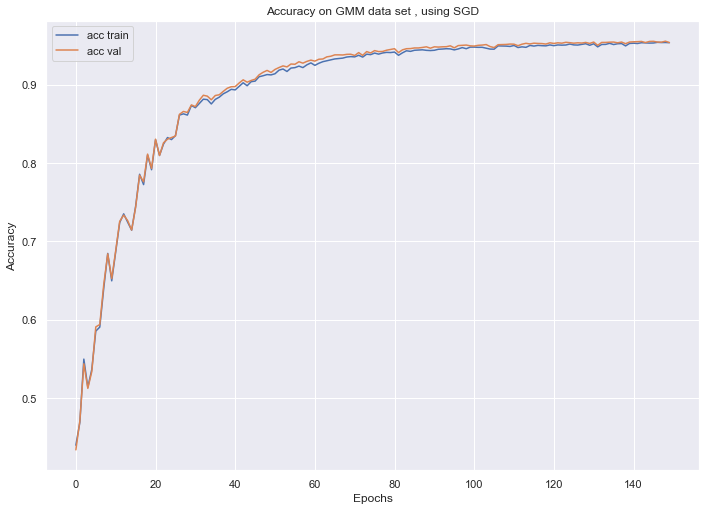

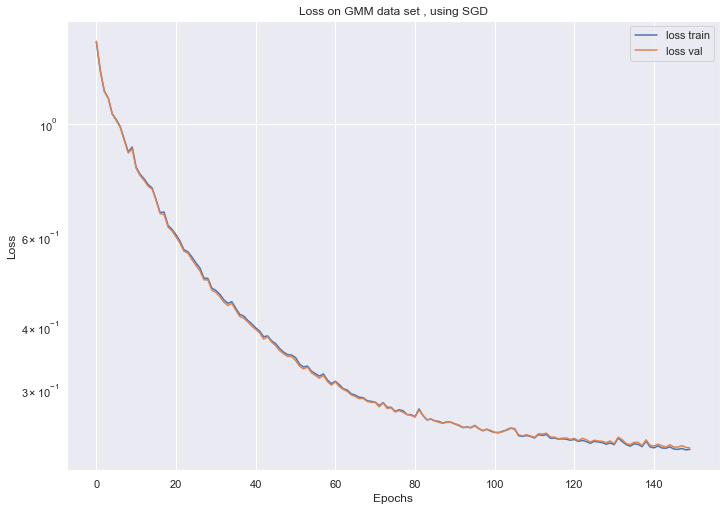

In [144]:

mat=scipy.io.loadmat("GMMData.mat")

y=mat["Ct"]
x=mat["Yt"]


y_val=mat["Cv"]
x_val=mat["Yv"]
optimize_RNN(x.T,y.T,x_val.T,y_val.T,data_set="GMM",depth=3,width=20,iters=150)
print("")

 # Experiments and failures  network arch:

We spent alot of time trying to handle vanishing or exploding gradient , during the model arch process we had a hard time understading why the model didn't learn. The problem after debugging was either saturation of the model due to tanh sending all the values to 1 or minus 1 beacuse the wieghts are too big , or beacuse ReLU exploded the gradient. We were unaware of the start that exploding graidnet was the case and though perhaps the learning rate was too big , or maybe the batchsize. At start we tried to lower the size of the weights to enchance stability , but after a certain epoch , for each learning we choose , we either stopped progressing at all beacuse he decreased too much , or the loss starting to increase and accuracy decreased.

 Therefor we had to try different combination of tanh and relu in order to maintain stability , we tried to make tanh encapsulate the layer and ReLU serve as an activation layer for the middle step in the RNN network but the graident still exploded , after debugging we realized which part of the network tends to explode and applied tanh there , which helped the stability of the netowrk and finally learning could begin.

## Stability and depth :
As we increased the depth the stability decreased , which we balanced out using the width of the network. For a depth of 4 the hidden layers size had to be 10 for the
training to remain stable , for a depth of 3 we had to use 20 layers. We believe we could improve the results if we managed to stablized the training and we used those hyper-parameters for
testing.

### Depth = 2  network width =100 , iter =150
A shallow net results in :
final accuracy for train is 0.94508
final accuracy for val is 0.94816

### Depth =3 , network width=20 , iter =150

We can see that they still remain competitive even with a smaller amount of weights , and the best result were achieved using the current configuration , the amount of weights
is still large , and the depth allow more non-linear patterns to emerge then a shallow network with more weights.

final accuracy for train is 0.95224
final accuracy for val is 0.9544
### Depth =4 , network width=10 , iter =150
a much deeper net , with less weights overall despite being deeper managed to surpass the previous acurracy with a faster training time. We believe the results stem from
the network ability to express more complicated patterns as the depth increases.
final accuracy for train is 0.94668
final accuracy for val is 0.94704

# Question 2.5 - only 200 samples


final accuracy for train is 0.995
final accuracy for val is 0.91504


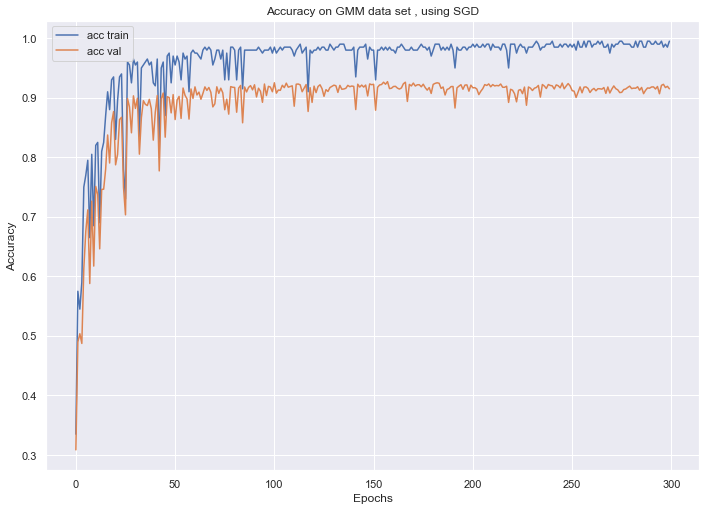

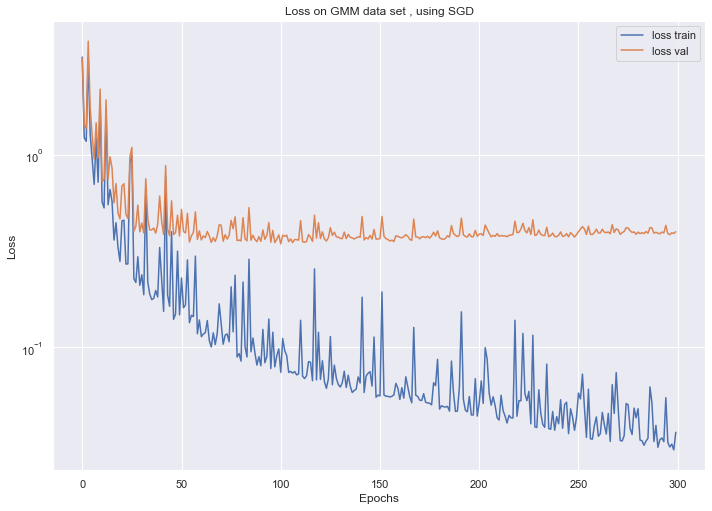

In [162]:
mat=scipy.io.loadmat("GMMData.mat")
import random

y=mat["Ct"]
x=mat["Yt"]
indices=random.sample(range((x.shape[1])),200)

x=x[:,indices]

y=y[:,indices]
y_val=mat["Cv"]
x_val=mat["Yv"]
optimize_RNN(x.T,y.T,x_val.T,y_val.T,data_set="GMM",depth=2,width=100,iters=300,batch_size=8,lr=0.1)

print("")

# Experiments

### depth of 3 , width 20 , lr = 0.01 , batchsize =8
final accuracy for train is 0.99
final accuracy for val is 0.87968


### depth of 4 , width 10 , lr = 0.01 , batchsize = 8
final accuracy for train is 0.985
final accuracy for val is 0.82288

### depth of 2 , width 100 , lr = 0.01 , batchsize =8
final accuracy for train is 0.995
final accuracy for val is 0.91504

The optimal result is 1.0 since we expect extreme over fitting  , we expect a network to over fit better as the amount of weights increases  and therefor
the result is optimal with width of 100 and depth of 2.

### How did the result changes
The train accuracy increased dramatically to 0.995 , a perfect fitting of the data   , which makes sense since the training data is 200 ,
compared to 25,000 therefor it is easier to over-fit with a smaller sample size. But the validation accuracy is lower  compared to using the whole
dataset , which indicate over-fitting. When we used the entire dataset the training accuracy and evaluation accuracy (and losses) remained similar , but a big  disparity is present
when using only 200 samples.

